## TAZ Setup

Download Wasatch Front TAZs from WFRC [https://data.wfrc.org/datasets/access-to-opportunities-work-related-taz-based/] (https://data.wfrc.org/datasets/access-to-opportunities-work-related-taz-based/)

Calculate a centroid point for each TAZ from the TAZ shapefile. If you have an "Advanced" license of ArcGIS Pro you can do this with the "Feature to Point" tool. Otherwise, just fire up QGIS, open the TAZ layer, Go to the menu -> Vector -> Geometry tools -> polygon centroid and create a centroid point layer.

Then, load in the BikePedAuto layer and snap the resulting centroids to the network.

Save the resulting layer to `shp/taz_wfrc.gdb/taz_centroids_snapped`

Finally, create a testing layer with 20 - 30 randomly selected centroids and save to `shp/taz_wfrc.gdb/taz_centroids_sample`

Finally, rename the relevant fields to "HH" and "JOB" (e.g. JOB_19 --> JOB).

## Baseline Network Setup

1. Download Multimodal network dataset from [https://gis.utah.gov/data/transportation/street-network-analysis/] and extract to the `shp` folder


The cells below:
2. Copy the Multimodal network dataset and delete the layers that will be replaced with clipped versions
3. Clip the NetworkDataset>BikePedAuto and NetworkDataset>Network_Dataset_ND_Junctions layers using 5 mile buffer around the Wasatch Front TAZ layer
4. Create and fill RoadClass attribute to a usable hierarchy value
5. Join the TDM data for speeds

** Note: This notebook can be run either within or outside of ArcGIS Pro. It is recommended to run this notebook outside of ArcGIS Pro. If running within Pro, sometimes sequential execution of the cells below will produce a "Cannot acquire a lock" error. If this happens, just re-run the cell. Esri weirdness! **

### Network Setup Notes

Vertical Elevation - the current dataset does not contain the necessary attributes to establish vertical connectivity. Elevation is not used.

Hierarchy - oddly, adding a heirarchy for routing seems to worsen performance. Hierarchy is not used.

In [ ]:
import sys
import os
import arcpy
import shutil

import pandas as pd
from arcgis.features import SpatialDataFrame

src = os.path.join(os.path.abspath("."), 'src')
if src not in sys.path:
    sys.path.append(src)
    
from ato_tools import ato

# Set the XYResolution environment to a linear unit
arcpy.env.XYResolution = "0.01 Meters"
arcpy.env.XYTolerance = "0.1 Meters"

base_path = os.path.abspath(".")

arcpy.CheckOutExtension("network")

In [ ]:
source_mm_network_dataset = os.path.join(base_path, r"shp\MM_NetworkDataset_11082021.gdb\NetworkDataset")
tdm_shp_path = os.path.join(base_path, r"shp\Master_Segs_withFactors_20200504_BY2019SegSummary\Master_Segs_withFactors_20200504_BY2019SegSummary.shp")

base_gdb = os.path.join(base_path, "baseline.gdb")

In [ ]:
# if baseline GDB exists, delete it
if os.path.isdir(base_gdb):
    shutil.rmtree(base_gdb)

arcpy.management.CreateFileGDB(base_path, "baseline")

In [ ]:
# Copy NetworkDataset to our working GDB - 50 seconds
arcpy.management.Copy(
    source_mm_network_dataset, 
    os.path.join(base_gdb, "NetworkDataset")
)

In [ ]:
# delete existing network
arcpy.management.Delete(os.path.join(base_gdb, r"NetworkDataset\NetworkDataset_ND"))

In [ ]:
# if open in ArcGIS Pro, remove all layers
try:
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    mp = aprx.listMaps("Map")[0]
    for rmlyr in mp.listLayers():    
        if rmlyr.name not in ['World Topographic Map', 'World Hillshade']:        
            mp.removeLayer(rmlyr)
except OSError:
    pass

In [ ]:
arcpy.management.MakeFeatureLayer(
    os.path.join(base_gdb, r"NetworkDataset\BikePedAuto"), 
    "BPA"
)

In [ ]:
# add hierarchy to clipped BikePedAuto
arcpy.management.AddField(
    "BPA", 
    "hierarchy", 
    "SHORT"
)

In [ ]:
# if this fails due to a "lock" error try running again
# note, this field was previously RoadClass and is now CartoCode
expression = "getClass(!CartoCode!)"

codeblock = """
hierarchy = {
	'1 Interstates': 1,
	'2 US Highways, Separated': 1,
	'3 - Paved Shared Use': 3,
	'3 US Highways, Unseparated': 1,
	'4 Major State Highways, Separated': 1,
	'5 Major State Highways, Unseparated': 1,
	'6 Other State Highways (Institutional)': 1,
	'7 Ramps, Collectors': 2,
	'8 - Bridge, Tunnel': 2,
	'8 Major Local Roads, Paved': 2,
	'9 - Link': 3,
	'9 Major Local Roads, Not Paved': 3,
	'10 Other Federal Aid Eligible Local Roads': 2,
	'11 Other Local, Neighborhood, Rural Roads': 3,
	'12 Other': 3,
	'13 Non-road feature': None,
	'14 Driveway': None,
	'15 Proposed': None,
	'17 Service Access Roads': None,
	'99 - UDOT FAE Calibration (Non-Road Feature)': None
}
def getClass(rc):
    return 3 if rc is None else hierarchy[rc]
"""

# Execute CalculateField 
arcpy.management.CalculateField("BPA", "hierarchy", expression, "PYTHON3", codeblock)

In [ ]:
# Select non-road features
arcpy.management.SelectLayerByAttribute(
    "BPA", 
    "NEW_SELECTION", 
    "hierarchy IS NULL"
)

In [ ]:
# Create a 5 mile buffer
arcpy.analysis.Buffer(
    in_features = os.path.join(base_path, r"shp\taz_wfrc.gdb\ATO"),
    out_feature_class = os.path.join(base_gdb, "taz_buffer"),
    buffer_distance_or_field = "5 Miles",
    dissolve_option = "ALL"
)

In [ ]:
# Select all segments outside buffer
arcpy.management.SelectLayerByLocation(
    in_layer = "BPA",
    overlap_type = 'INTERSECT', 
    select_features = os.path.join(base_gdb, "taz_buffer"),
    selection_type = 'ADD_TO_SELECTION',
    invert_spatial_relationship = True
)

In [ ]:
arcpy.management.DeleteFeatures("BPA") # 50 seconds
# sometimes this fails - removing from map and adding again seems to help

### Join in Speed Data
WFRC has provided free flow and peak hour speed data from their TDM. We will join this to the network dataset for later use when roughly estimating the short-term improvement in automobile mobility associated with roadway widening.

In [ ]:
arcpy.conversion.FeatureClassToFeatureClass(
    tdm_shp_path,
    base_gdb,
    "TDM"
)

In [ ]:
# Create and calculate PK_SPD field based on minimum (peak time) speed
arcpy.management.CalculateField(
    "TDM", 
    "PK_SPD", 
    "min(!AM_SPD!,!MD_SPD!,!PM_SPD!,!EV_SPD!)", 
    "PYTHON3", '', "DOUBLE"
)

In [ ]:
# Spatially join TDM travel times to MM network:
field_spec = """Name "Name" true true false 50 Text 0 0,First,#,BikePedAuto,Name,0,50;
Oneway "Oneway" true true false 2 Text 0 0,First,#,BikePedAuto,Oneway,0,2;
Speed "Speed" true true false 2 Short 0 0,First,#,BikePedAuto,Speed,-1,-1;
AutoNetwork "AutoNetork" true true false 1 Text 0 0,First,#,BikePedAuto,AutoNetwork,0,1;
BikeNetwork "BikeNetwork" true true false 1 Text 0 0,First,#,BikePedAuto,BikeNetwork,0,1;
PedNetwork "PedNetwork" true true false 1 Text 0 0,First,#,BikePedAuto,PedNetwork,0,1;
SourceData "SourceData" true true false 15 Text 0 0,First,#,BikePedAuto,SourceData,0,15;
DriveTime "DriveTime" true true false 8 Double 0 0,First,#,BikePedAuto,DriveTime,-1,-1;
BikeTime "BikeTime" true true false 8 Double 0 0,First,#,BikePedAuto,BikeTime,-1,-1;
PedestrianTime "PedestrianTime" true true false 8 Double 0 0,First,#,BikePedAuto,PedestrianTime,-1,-1;
Length_Miles "Length_Miles" true true false 8 Double 0 0,First,#,BikePedAuto,Length_Miles,-1,-1;
ConnectorNetwork "ConnectorNetwork" true true false 1 Text 0 0,First,#,BikePedAuto,ConnectorNetwork,0,1;
CartoCode "CartoCode" true true false 50 Text 0 0,First,#,BikePedAuto,CartoCode,0,50;
AADT "AADT" true true false 4 Long 0 0,First,#,BikePedAuto,AADT,-1,-1;
AADT_YR "AADT_YR" true true false 4 Text 0 0,First,#,BikePedAuto,AADT_YR,0,4;
BIKE_L "BIKE_L" true true false 4 Text 0 0,First,#,BikePedAuto,BIKE_L,0,4;
BIKE_R "BIKE_R" true true false 4 Text 0 0,First,#,BikePedAuto,BIKE_R,0,4;
VERT_LEVEL "VERT_LEVEL" true true false 25 Text 0 0,First,#,BikePedAuto,VERT_LEVEL,0,25;
hierarchy "hierarchy" true true false 2 Short 0 0,First,#,BikePedAuto,hierarchy,-1,-1;
FF_SPD "FF_SPD" true true false 8 Double 0 0,First,#,TDM,FF_SPD,-1,-1;
PK_SPD "PK_SPD" true true false 8 Double 0 0,First,#,TDM,PK_SPD,-1,-1"""

arcpy.analysis.SpatialJoin(
    "BPA", 
    "TDM", 
    os.path.join(base_gdb, "TDM_SpatialJoin"), 
    "JOIN_ONE_TO_ONE", 
    "KEEP_ALL", 
    field_spec, 
    "HAVE_THEIR_CENTER_IN", # "SHARE_A_LINE_SEGMENT_WITH"
)

In [ ]:
# copy attributes back to the BikePedAuto
arcpy.management.JoinField(
    "BPA", 
    "OBJECTID", 
    "TDM_SpatialJoin", 
    "TARGET_FID", 
    "FF_SPD;PK_SPD"
)

In [ ]:
# Calculate drive times based on peak hour TDM speeds
codeblock = """
def getSpeed(spd, len):
    return None if spd is None else float(60*len/spd)
"""

arcpy.management.CalculateField(
    "BPA", 
    "DriveTime_Peak", 
    "getSpeed(!PK_SPD!, !Length_Miles!)", 
    "PYTHON3", codeblock, "DOUBLE"
)
arcpy.management.CalculateField(
    "BPA", 
    "DriveTime_FF", 
    "getSpeed(!FF_SPD!, !Length_Miles!)", 
    "PYTHON3", codeblock, "DOUBLE"
)

In [ ]:
# Update Drive Time based on TDM peak value when set/exists
arcpy.management.CalculateField(
    "BPA", 
    "DriveTime", 
    "!DriveTime! if !DriveTime_Peak! is None else !DriveTime_Peak!", 
    "PYTHON3", None, "DOUBLE")

In [ ]:
# clean up temporary layers
arcpy.management.Delete(os.path.join(base_gdb, "taz_buffer"))
arcpy.management.Delete("TDM_SpatialJoin")
arcpy.management.Delete("TDM")

In [ ]:
nd = os.path.join(base_gdb, r"NetworkDataset\NetworkDataset_ND")

In [ ]:
ato.build(nd)

## Testing and Baseline Scoring

Run our testing to make sure the network is producing valid scores.

If so, calculate ATO for our baseline modal networks.

Finally, we create a copy of the baseline network dataset to use as a template for scenario networks.

In [ ]:
# test for a valid network
# if fails, re-run the cell above ("delete and recreate network")
drive_test = ato.test(nd, mode = "Driving")
transit_test = ato.test(nd, mode = "Transit")
cycling_test = ato.test(nd, mode = "Cycling")
if not drive_test and transit_test and cycling_test:
    print('Drive Test: {0} \n Transit Test:{1}\nCycling Test:{2}'.format(drive_test, transit_test, cycling_test))

In [ ]:
# run the baseline ATO calcs for auto 
# and transit and save the resulting tables in the GDB

In [ ]:
ato.score(
    "baseline.gdb",
    out_table="auto_baseline",
    mode = "Driving", 
    test = False
)

In [ ]:
ato.score(
    "baseline.gdb", 
    out_table="transit_baseline", 
    mode = "Transit",
    test = False
)

In [ ]:
ato.score(
    "baseline.gdb", 
    out_table="cycling_baseline", 
    mode = "Cycling",
    test = False
)

In [ ]:
# Create "template" to use for mods

# if open in ArcGIS Pro, remove all layers
try:
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    mp = aprx.listMaps("Map")[0]
    for rmlyr in mp.listLayers():    
        if rmlyr.name not in ['World Topographic Map', 'World Hillshade']:        
            mp.removeLayer(rmlyr)
except OSError:
    pass

if os.path.isdir(r"scenario\scenario_template.gdb"):
    shutil.rmtree(r"scenario\scenario_template.gdb")

arcpy.management.CreateFileGDB("scenario", "scenario_template")

# Copy our baseline network dataset to our dataset for modification
arcpy.management.Copy(
    r"baseline.gdb\NetworkDataset", 
    r"scenario\scenario_template.gdb\NetworkDataset"
)

# delete existing network
arcpy.management.Delete(r"scenario\scenario_template.gdb\NetworkDataset\NetworkDataset_ND")

## Bonus: Template Creation Instructions

Note: this step may never be needed. (Hence, the code below is disabled.)

In the even of a schema change for the underlying MM network dataset, a new network template will need to be created. The cells below provide a bit of information about how this is done. 

To create the template for this project from the MultiModal dataset template (shouldn't be necessary):
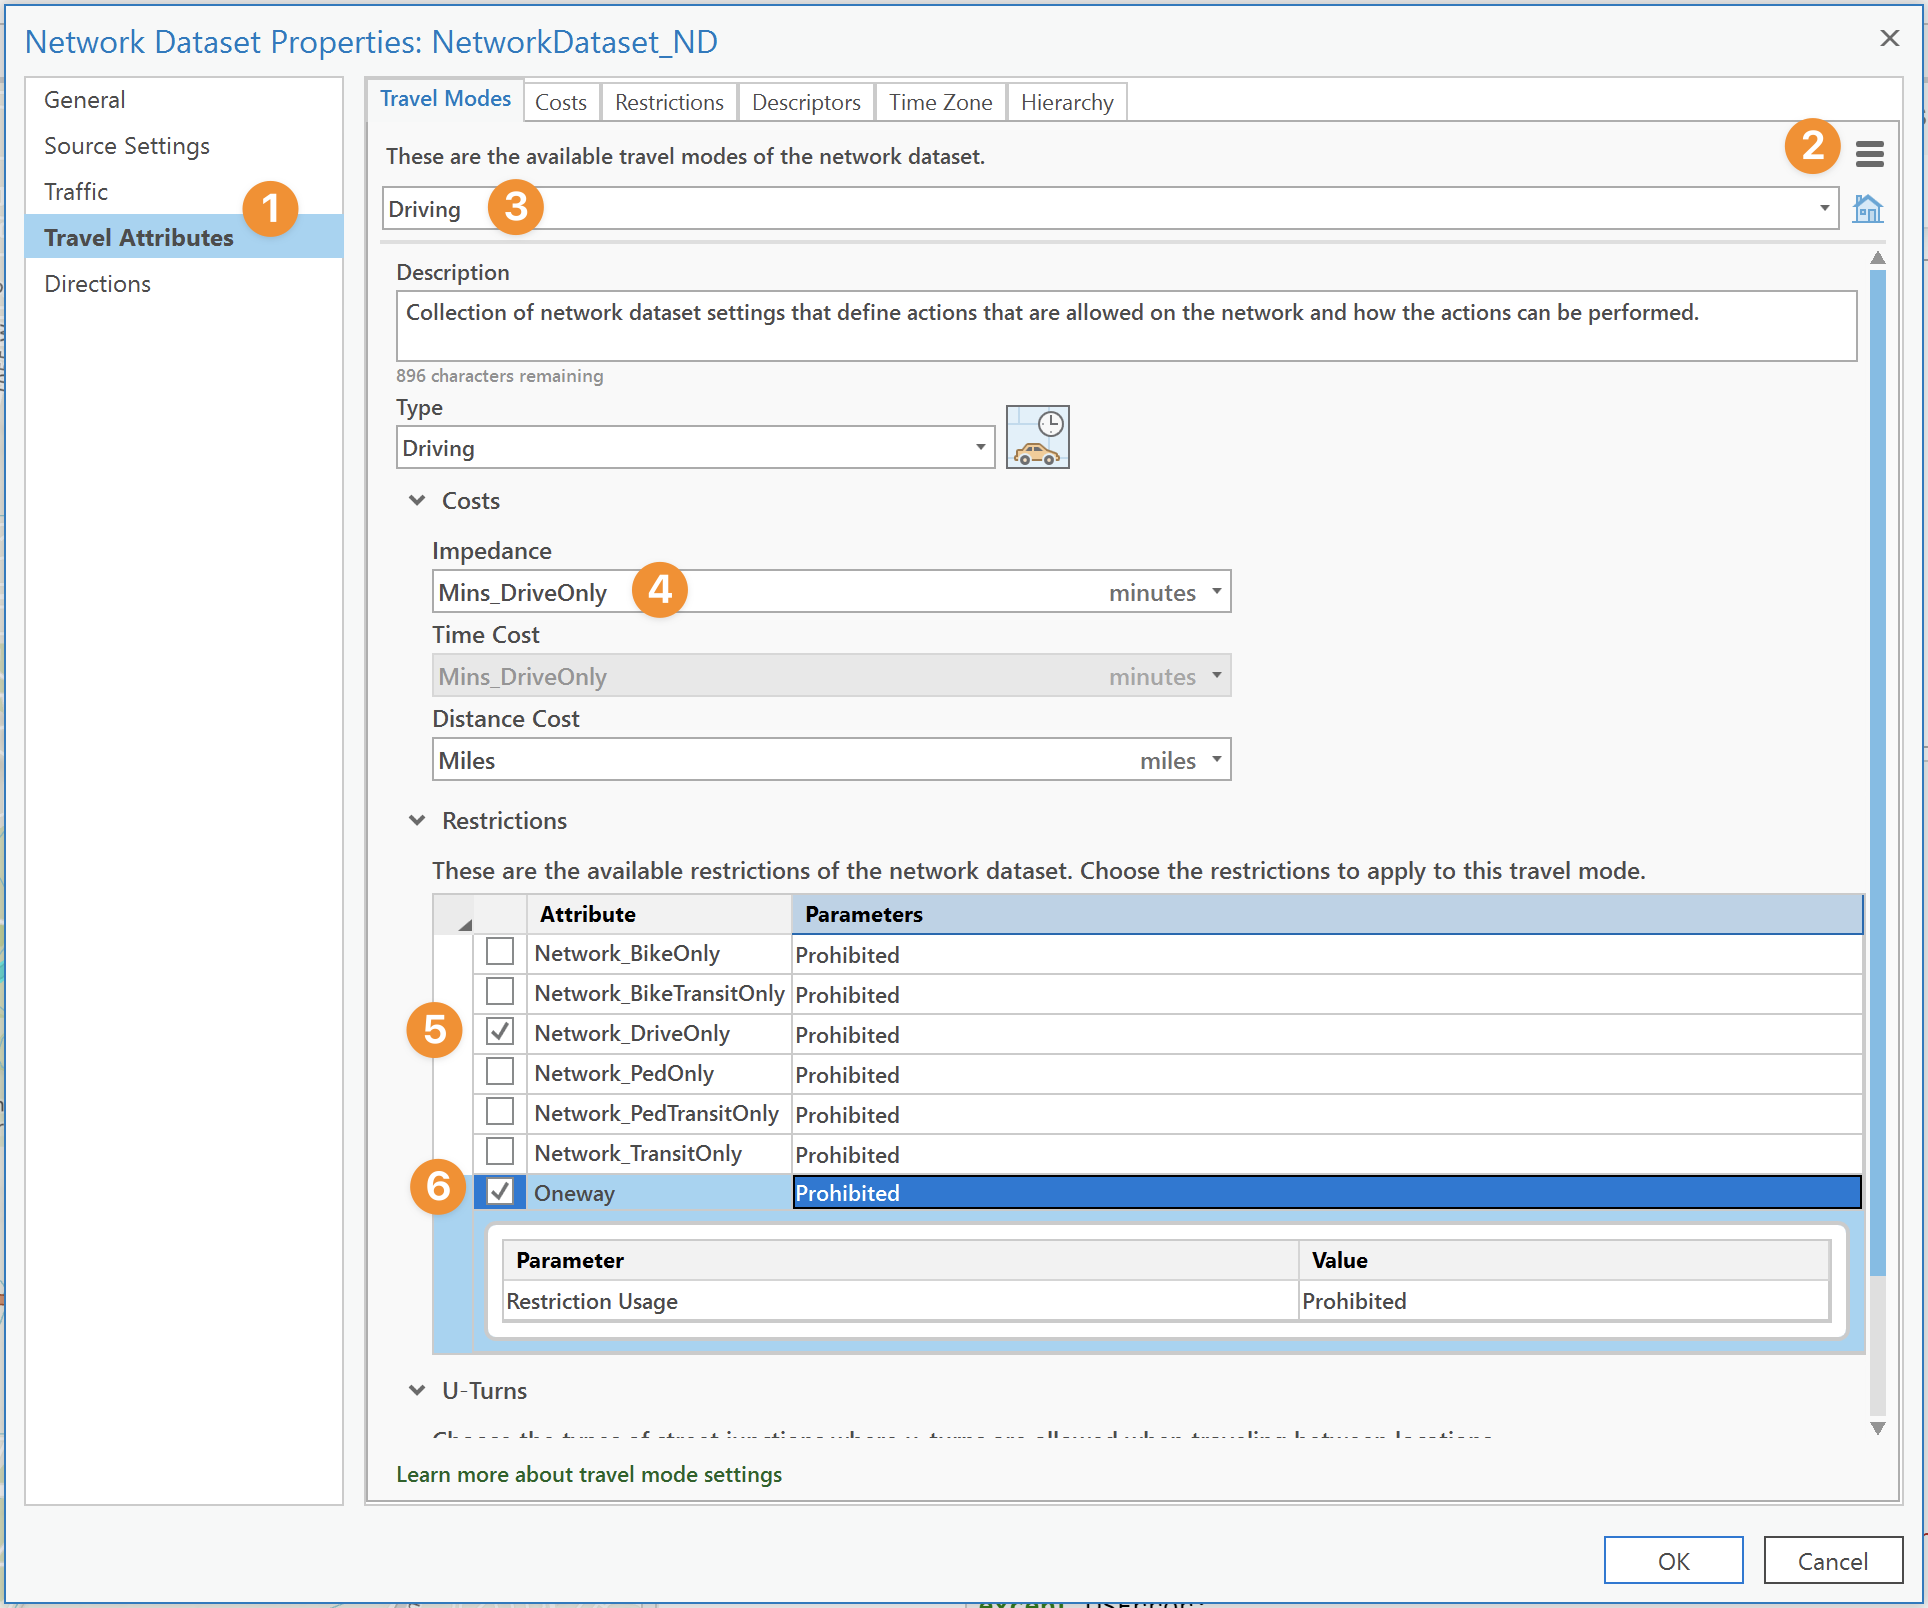

In [ ]:
# create template from MM network
if os.path.exists(os.path.join(base_path, "network_template.xml")):
    os.remove(os.path.join(base_path, "network_template.xml"))
    
arcpy.nax.CreateTemplateFromNetworkDataset(
    os.path.join(r"baseline.gdb\NetworkDataset", "NetworkDataset_ND"),
    os.path.join(base_path, "network_template.xml")
)